In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm
from functions import MODEL
#import prettytable

from collections import Counter
#from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM
import keras.backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

obj = MODEL()

Using TensorFlow backend.


In [2]:
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]
target_seq=pd.read_csv('data/target_seq.csv')[['target_uniprot','target_chembl','seq']]
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]

In [3]:
# Split indics into train/test
train_indices, test_indices = obj.split(DTI_index, 8)

In [4]:
# Train and test data
train_target = DTI_index.loc[train_indices][['target_uniprot']]
train_drug = DTI_index.loc[train_indices][['drug']]
test_target = DTI_index.loc[test_indices][['target_uniprot']]
test_drug = DTI_index.loc[test_indices][['drug']]

# Labels
train_y = DTI_index.loc[train_indices][['activity']]
test_y = DTI_index.loc[test_indices][['activity']]

print(train_target.shape, train_drug.shape, test_target.shape, test_drug.shape, train_y.shape, test_y.shape)

(49299, 1) (49299, 1) (12325, 1) (12325, 1) (49299, 1) (12325, 1)


In [5]:
# Add sequencexccv  v xfc data to data index
seq = []
for target in tqdm(train_target['target_uniprot']):
    try:
        seq.append(target_seq[target_seq['target_uniprot']==target]['seq'].values[0])
    except:
        print(target)
train_target['seq'] = seq

100%|██████████| 49299/49299 [00:16<00:00, 2985.89it/s]


In [24]:
# Add sequencexccv  v xfc data to data index
seq = []
for target in tqdm(test_target['target_uniprot']):
    try:
        seq.append(target_seq[target_seq['target_uniprot']==target]['seq'].values[0])
    except:
        print(target)
test_target['seq'] = seq

100%|██████████| 12325/12325 [00:04<00:00, 2936.85it/s]


In [6]:
# Add smile strings to labels
seq = []
for drug in tqdm(train_drug['drug']):
    try:
        seq.append(drug_smiles[drug_smiles['drug']==drug]['smile'].values[0])
    except:
        print(target)
train_drug['seq'] = seq

100%|██████████| 49299/49299 [01:17<00:00, 638.28it/s]


In [25]:
# Add smile strings to labels
seq = []
for drug in tqdm(test_drug['drug']):
    try:
        seq.append(drug_smiles[drug_smiles['drug']==drug]['smile'].values[0])
    except:
        print(target)
test_drug['seq'] = seq

100%|██████████| 12325/12325 [00:18<00:00, 653.79it/s]


In [8]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

print(char_dict_target)
print("Target Dict Length:", len(char_dict_target))

print(char_dict_drug)
print("Drug dict Length:", len(char_dict_drug))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Target Dict Length: 20
{')': 1, 'i': 2, '@': 3, 'e': 4, 'I': 5, '+': 6, '/': 7, 'Z': 8, '[': 9, 's': 10, 'n': 11, 'c': 12, 'P': 13, '7': 14, 'O': 15, '4': 16, 'A': 17, 'L': 18, 'F': 19, 'B': 20, 'o': 21, 'C': 22, 'H': 23, '6': 24, '=': 25, 'S': 26, '2': 27, 'K': 28, 'N': 29, 'l': 30, '(': 31, '\\': 32, '5': 33, '#': 34, 'a': 35, '8': 36, '9': 37, '3': 38, 'r': 39, ']': 40, '-': 41, '1': 42, '.': 43}
Drug dict Length: 43


In [9]:
# Train
train_encode_target = obj.integer_encoding(train_target, char_dict_target) 
train_encode_drug = obj.integer_encoding(train_drug, char_dict_drug) 

In [26]:
# Test
test_encode_target = obj.integer_encoding(test_target, char_dict_target) 
test_encode_drug = obj.integer_encoding(test_drug, char_dict_drug) 

In [10]:
# padding sequences train
max_length = 1000
train_pad_target = pad_sequences(train_encode_target, maxlen=max_length, padding='post', truncating='post')
train_pad_drug = pad_sequences(train_encode_drug, maxlen=max_length, padding='post', truncating='post')
train_pad_target.shape, train_pad_drug.shape

((49299, 1000), (49299, 1000))

In [27]:
# padding sequences test
max_length = 1000
test_pad_target = pad_sequences(test_encode_target, maxlen=max_length, padding='post', truncating='post')
test_pad_drug = pad_sequences(test_encode_drug, maxlen=max_length, padding='post', truncating='post')
test_pad_target.shape, test_pad_drug.shape

((12325, 1000), (12325, 1000))

In [11]:
# One hot encoding of sequences
train_ohe_target = to_categorical(train_pad_target)
train_ohe_drug = to_categorical(train_pad_drug)
train_ohe_target.shape, train_ohe_drug.shape

((49299, 1000, 21), (49299, 1000, 44))

In [12]:
# label/integer encoding output variable: (y)
le = LabelEncoder()
y_train_le = le.fit_transform(train_y['activity'].tolist())
y_train_le.shape

(49299,)

In [13]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_train.shape

(49299, 3)

In [28]:
# label/integer encoding output variable: (y)
le = LabelEncoder()
y_test_le = le.fit_transform(test_y['activity'].tolist())
y_test_le.shape

(12325,)

In [30]:
# One hot encoding of outputs
y_test = to_categorical(y_test_le)
y_test.shape

(12325, 3)

In [14]:
# Attention class
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [19]:
# Model Architecture
input_target = Input(shape=(1000,))
emb_target = Embedding(21, 128, input_length=max_length)(input_target) 
conv_target_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(emb_target)
pool_target_1 = MaxPooling1D(pool_size=2)(conv_target_1)
att_in_target = Bidirectional(CuDNNLSTM(32, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_target_1)
att_out_target = attention()(att_in_target)
#flat_1_target = Flatten()(att_out_target)

# softmax classifier
#x_output_target = Dense(3, activation='softmax')(att_in_target)

input_drug = Input(shape=(1000,))
emb_drug = Embedding(44, 128, input_length=max_length)(input_drug) 
conv_drug_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(emb_drug)
pool_drug_1 = MaxPooling1D(pool_size=2)(conv_drug_1)
att_in_drug = Bidirectional(CuDNNLSTM(32, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_drug_1)
att_out_drug = attention()(att_in_drug)
#flat_1_drug = Flatten()(att_out_drug)

concat = Concatenate()([att_out_target,att_out_drug])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
#dense_2_dropout = Dropout(0.5)(dense_1_dropout)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)

# softmax classifier
x_output = Dense(3, activation='softmax')(dense_2)

model1 = Model(inputs=[input_target, input_drug], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1000, 128)    2688        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1000, 128)    5632        input_4[0][0]                    
____________________________________________________________________________________________

In [20]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
histories = []

In [21]:
history = model1.fit(
    [train_pad_target, train_pad_drug], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es]
    )

p - loss: 0.6973 - accuracy: 0.7074 - val_loss: 0.7259 - val_accuracy: 0.6997
Epoch 82/500
39439/39439 [==============================] - 19s 477us/step - loss: 0.6979 - accuracy: 0.7065 - val_loss: 0.7315 - val_accuracy: 0.6961
Epoch 83/500
39439/39439 [==============================] - 19s 478us/step - loss: 0.6935 - accuracy: 0.7095 - val_loss: 0.7474 - val_accuracy: 0.6880
Epoch 84/500
39439/39439 [==============================] - 19s 475us/step - loss: 0.6952 - accuracy: 0.7088 - val_loss: 0.7277 - val_accuracy: 0.6974
Epoch 85/500
39439/39439 [==============================] - 19s 474us/step - loss: 0.6826 - accuracy: 0.7137 - val_loss: 0.7304 - val_accuracy: 0.6972
Epoch 86/500
39439/39439 [==============================] - 19s 474us/step - loss: 0.6838 - accuracy: 0.7154 - val_loss: 0.7322 - val_accuracy: 0.6992
Epoch 87/500
39439/39439 [==============================] - 19s 477us/step - loss: 0.6821 - accuracy: 0.7160 - val_loss: 0.7568 - val_accuracy: 0.6846
Epoch 88/500
394

In [77]:
model1.save('models/drugTargetSeqOnly.h5')

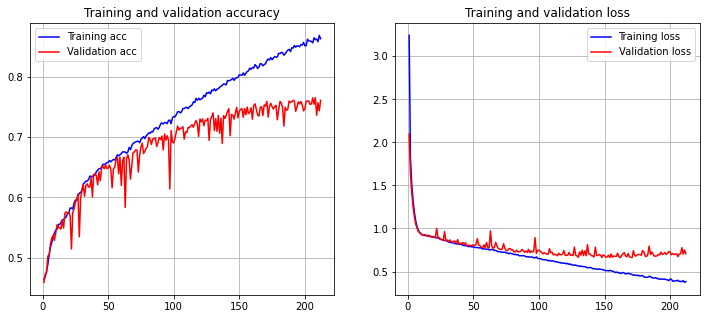

In [80]:
obj.plot_history(history)

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y_pred_keras = model1.predict([test_pad_target, test_pad_drug])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#y_pred_keras = model1.predict([test_pad_target, test_pad_drug])
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

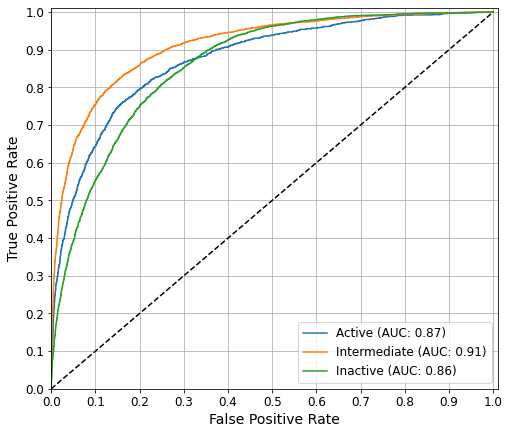

In [74]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax.plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
#ax.set_title('Receiver operating characteristic ('+train_test+')', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
#ax.text(0.035, 0.925, 'Average AUC:'+str(np.round(np.mean(roc_auc),3)))
ax.grid()
ax.legend(fontsize=12)
plt.savefig('roc.png', dpi=500, bbox_inches='tight')

In [66]:
precision = dict()
recall = dict()
average_precision = dict()
#y_pred_keras = model.predict(X)[0]
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_keras[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_keras[:, i])

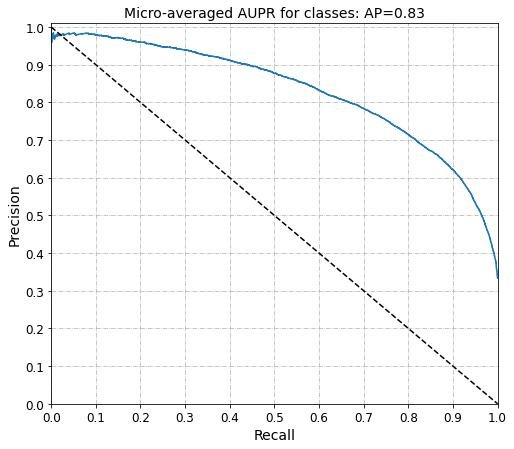

In [76]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred_keras.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_keras, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title(
    'Micro-averaged AUPR for classes: AP={0:0.2f}'
    .format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('aupr.png', dpi=500, bbox_inches='tight')

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
12325/12325 [==============================] - 2s 180us/step
test loss, test acc: [0.7143899965963305, 0.750831663608551]


In [ ]:
y_pred_test = model1.predict(X)[0]

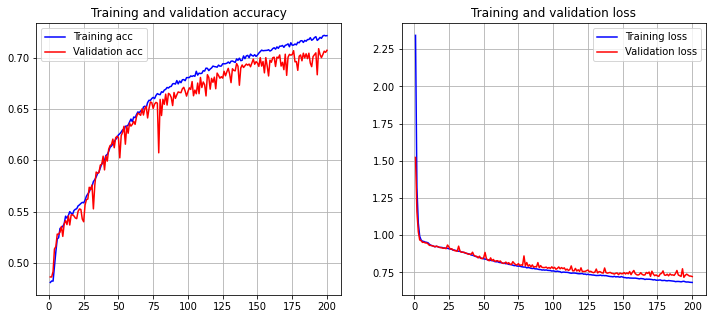

In [27]:
obj.plot_history(histories[0])

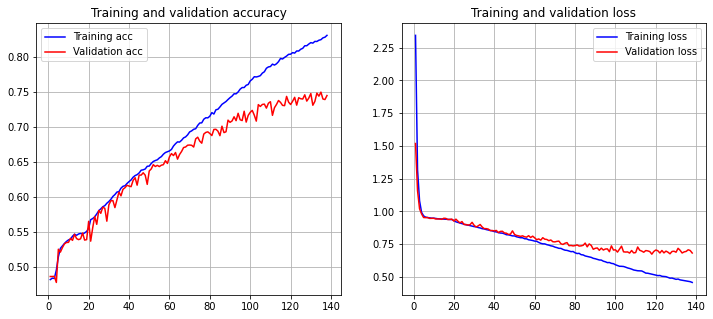

In [23]:
obj.plot_history(histories[0])

In [ ]:
obj.plot_history(histories[0])

In [ ]:
for a in histories[0].history:
    print(a)